# Global settings

In [1]:
%matplotlib inline

#%load_ext autoreload  # Autoreload has a bug : when you modify function in source code and run again, python kernel hangs :(
#%autoreload 2

import datetime as dt

import sys, importlib

from functions import *
importlib.reload(sys.modules['functions'])

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import datetime as dt

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np   
  
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import entropy

from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


import nltk
import codecs

#from nltk.corpus.reader.api import CorpusReader
#from nltk.corpus.reader.api import CategorizedCorpusReader

from nltk import pos_tag, sent_tokenize, wordpunct_tokenize

import pandas_profiling

from bs4 import BeautifulSoup

DATA_PATH = os.path.join("datasets", "stackexchange")
#DATA_PATH = os.path.join(DATA_PATH, "out")

#DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "QueryResults_20190101-20200620.csv")
#DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "QueryResults 20200301-20200620_1.csv")

DATA_PATH_FILE = os.path.join(DATA_PATH, "*.csv")
ALL_FILES_LIST = glob.glob(DATA_PATH_FILE)

ALL_FEATURES = []

MODEL_CLIENT_FEATURES = ['TotalPricePerMonth', 'DescriptionNormalized', 'HasEverCancelled', 'BoughtTopValueProduct' ]


plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
from seaborn import boxplot
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :

'''
RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)
'''


RECOMPUTE_GRIDSEARCH = False  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = True # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX

#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures

### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from nltk.cluster import KMeansClusterer # NLTK algorithm will be useful for cosine distance

SAVE_API_MODEL = True # If True : API model ill be saved
API_MODEL_PICKLE_FILE = 'API_model_PJ6.pickle'


/home/francois/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Doc2vec settings

In [2]:
DOC2VEC_TRAINING_SAVE_FILE = 'doc2vec_model'
#doc2vec_fname = get_tmpfile(DOC2VEC_TRAINING_SAVE_FILE)

from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import remove_stopwords

import time

from gensim.test.utils import get_tmpfile

import gensim

#model.save(fname)
#model = Doc2Vec.load(fname)  # you can continue training with the loaded model!


In [3]:
ALL_FILES_LIST

['datasets/stackexchange/QueryResults 20200301-20200620_1.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_6.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_2.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_5.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_4.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_3.csv']

# Load data

In [4]:
import pandas as pd

pd.set_option('display.max_columns', None)

feats_list = ['Title', 'Body', 'Tags']

def load_data(data_path=DATA_PATH):
    csv_path = DATA_PATH_FILE
    df_list = []
    
    for f in ALL_FILES_LIST:
        print(f'Loading file {f}')
        
        df_list.append(pd.read_csv(f, sep=',', header=0, encoding='utf-8', usecols=feats_list))
        
    return pd.concat(df_list)


In [5]:
df = load_data()
df.reset_index(inplace=True)

Loading file datasets/stackexchange/QueryResults 20200301-20200620_1.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_6.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_2.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_5.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_4.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_3.csv


In [6]:
df

,index,Body,Title,Tags
0,0,<p>Will a <code>StreamBuilder</code> always st...,Does StreamBuilder always listen in the first ...,<flutter>
1,1,<p>The problem was not the filtering - I was a...,NaN,NaN
2,2,<p>My two cents:</p>\n\n<p>You can specify the...,NaN,NaN
3,3,<p>if you want to step up from that manual con...,NaN,NaN
4,4,<p>The parent function is already asynchronous...,NaN,NaN
...,...,...,...,...
299995,49995,<p>I wanted to use turicreate library which do...,How can I effectively downgrade python in Linux?,<python><python-3.x><linux><pip><archlinux>
299996,49996,<p>Please make sure there are only 'male' &amp...,NaN,NaN
299997,49997,<p>Either use <code>android:requestLegacyExter...,NaN,NaN
299998,49998,<p>I have a messagedialog to update after some...,MessageBox freezes GTK,<python><python-3.x><gtk3>


## Drop NA and Remove html tags

In [7]:
df.dropna(subset=['Body'], axis=0, inplace=True)

In [8]:
# Or with beautifulsoup
df.loc[:, 'Body'] = df['Body'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

In [9]:
df

,index,Body,Title,Tags
0,0,Will a StreamBuilder always start listening to...,Does StreamBuilder always listen in the first ...,<flutter>
1,1,The problem was not the filtering - I was acce...,NaN,NaN
2,2,My two cents:\nYou can specify the start time ...,NaN,NaN
3,3,if you want to step up from that manual config...,NaN,NaN
4,4,"The parent function is already asynchronous, s...",NaN,NaN
...,...,...,...,...
299995,49995,I wanted to use turicreate library which doesn...,How can I effectively downgrade python in Linux?,<python><python-3.x><linux><pip><archlinux>
299996,49996,Please make sure there are only 'male' & 'fema...,NaN,NaN
299997,49997,Either use android:requestLegacyExternalStorag...,NaN,NaN
299998,49998,I have a messagedialog to update after some de...,MessageBox freezes GTK,<python><python-3.x><gtk3>


In [10]:
# Converting tags from <tag 1><tag2><tag3> to tag1 tag2 tag3
df.loc[:, 'Tags'] = df['Tags'].str.replace('<', '') 
df.loc[:, 'Tags'] = df.loc[:, 'Tags'].str.replace('>', ' ') 
df.loc[:, 'Tags'] = df.loc[:, 'Tags'].str.rstrip()

In [11]:
df

,index,Body,Title,Tags
0,0,Will a StreamBuilder always start listening to...,Does StreamBuilder always listen in the first ...,flutter
1,1,The problem was not the filtering - I was acce...,NaN,NaN
2,2,My two cents:\nYou can specify the start time ...,NaN,NaN
3,3,if you want to step up from that manual config...,NaN,NaN
4,4,"The parent function is already asynchronous, s...",NaN,NaN
...,...,...,...,...
299995,49995,I wanted to use turicreate library which doesn...,How can I effectively downgrade python in Linux?,python python-3.x linux pip archlinux
299996,49996,Please make sure there are only 'male' & 'fema...,NaN,NaN
299997,49997,Either use android:requestLegacyExternalStorag...,NaN,NaN
299998,49998,I have a messagedialog to update after some de...,MessageBox freezes GTK,python python-3.x gtk3


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299920 entries, 0 to 299999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   299920 non-null  int64 
 1   Body    299920 non-null  object
 2   Title   149323 non-null  object
 3   Tags    149323 non-null  object
dtypes: int64(1), object(3)
memory usage: 11.4+ MB


In [13]:
df.sample(100)

,index,Body,Title,Tags
143476,43476,Use a firewall\nAllow for third-party identity...,NaN,NaN
254245,4245,"In the docker-compose file, you are creating t...",NaN,NaN
182873,32873,Using the following function in a user variabl...,NaN,NaN
241398,41398,"Currently, I try to use parameterized MDX via ...",When using parameterized MDX via OLEDB in SSAS...,mdx parameterized
283591,33591,I am facing a problem with write or update req...,Permission denied on write/create when checkin...,firebase flutter google-cloud-firestore permis...
254207,4207,You can use something like this for python and...,NaN,NaN
169796,19796,I am creating a web app with an angular front-...,Angular CLI + Flask app runs and displays with...,python angular flask
51610,1610,Can someone help me make sense of the followin...,Weird issue with boost 1.69.0 and openmpi 2.1.2,boost openmpi
133994,33994,The program shown below prints this Apple Clan...,NaN,NaN
106666,6666,ionic 4 capacitor camera plugin after taking a...,how can I successfuly sanitise taken photo in ...,camera ionic4 capacitor angular-dom-sanitizer


In [14]:
df

,index,Body,Title,Tags
0,0,Will a StreamBuilder always start listening to...,Does StreamBuilder always listen in the first ...,flutter
1,1,The problem was not the filtering - I was acce...,NaN,NaN
2,2,My two cents:\nYou can specify the start time ...,NaN,NaN
3,3,if you want to step up from that manual config...,NaN,NaN
4,4,"The parent function is already asynchronous, s...",NaN,NaN
...,...,...,...,...
299995,49995,I wanted to use turicreate library which doesn...,How can I effectively downgrade python in Linux?,python python-3.x linux pip archlinux
299996,49996,Please make sure there are only 'male' & 'fema...,NaN,NaN
299997,49997,Either use android:requestLegacyExternalStorag...,NaN,NaN
299998,49998,I have a messagedialog to update after some de...,MessageBox freezes GTK,python python-3.x gtk3


# Regroup text features and clean

In [15]:
df.loc[:, 'Title'].fillna(value='', inplace=True)

In [16]:
df['all_text'] = df['Title'].astype(str) + '. ' +  df['Body'].astype(str)

In [17]:
df['all_text']

0         Does StreamBuilder always listen in the first ...
1         . The problem was not the filtering - I was ac...
2         . My two cents:\nYou can specify the start tim...
3         . if you want to step up from that manual conf...
4         . The parent function is already asynchronous,...
                                ...                        
299995    How can I effectively downgrade python in Linu...
299996    . Please make sure there are only 'male' & 'fe...
299997    . Either use android:requestLegacyExternalStor...
299998    MessageBox freezes GTK. I have a messagedialog...
299999    . I still miss some information to give you a ...
Name: all_text, Length: 299920, dtype: object

# Split training set, test set

In [18]:
df, df_train, df_test = custom_train_test_split_sample(df, None)

In [19]:
df_train.reset_index(drop=True, inplace=True)

In [20]:
df_train

,index,Body,Title,Tags,all_text
0,29281,I'm using Vividus to test my application.\nHow...,How to test downloading files with Vividus tool,automation ui-automation vividus,How to test downloading files with Vividus too...
1,34687,Answer relates to comment https://stackoverflo...,,NaN,. Answer relates to comment https://stackoverf...
2,43417,I'm trying to add a table (VDS) column and des...,Adding Table column and column descriptions fo...,wiki dremio,Adding Table column and column descriptions fo...
3,7005,"You may need to create a state machine, where ...",,NaN,". You may need to create a state machine, wher..."
4,28129,I think you can use ternary operator\n${(var =...,,NaN,. I think you can use ternary operator\n${(var...
...,...,...,...,...,...
269923,19908,"When you give an input, even if it is a charac...",,NaN,". When you give an input, even if it is a char..."
269924,9245,I am not sure I am fully clear on the spec but...,,NaN,. I am not sure I am fully clear on the spec b...
269925,31971,You correctly choosed recursive CTE. Unfortuna...,,NaN,. You correctly choosed recursive CTE. Unfortu...
269926,46909,Basically you are looking to add options to se...,,NaN,. Basically you are looking to add options to ...


In [21]:
df_test.reset_index(drop=True, inplace=True)

In [22]:
df_train_ori = df_train.copy(deep=True)
df_test_ori = df_test.copy(deep=True)

# Doc2Vec training

In [29]:
cnt_label = 0
InputDocs = []
for document in df_train['all_text']:  # TO DO : relaunch this training with df_train
    #InputDocs.append(TaggedDocument(document,[cnt_label]))
    
    doc_transformed = remove_stopwords(document)
    doc_toappend = gensim.utils.simple_preprocess(doc_transformed)
    
    InputDocs.append(TaggedDocument(doc_toappend,[cnt_label]))    
    cnt_label += 1

In [26]:
InputDocs

[TaggedDocument(words=['how', 'to', 'test', 'downloading', 'files', 'with', 'vividus', 'tool', 'using', 'vividus', 'to', 'test', 'my', 'application', 'how', 'can', 'test', 'the', 'file', 'was', 'downloaded', 'after', 'click', 'on', 'the', 'download', 'button'], tags=[0]),
 TaggedDocument(words=['answer', 'relates', 'to', 'comment', 'https', 'stackoverflow', 'com', 'questions', 'logs', 'are', 'not', 'loading', 'according', 'to', 'log', 'properties', 'noredirect', 'comment', 'works', 'here', 'spring', 'boot', 'release', 'info', 'main', 'com', 'example', 'testlog', 'logstarting', 'org', 'springframework', 'boot', 'logstarting', 'java', 'starting', 'on', 'laptop', 'vihojt', 'with', 'pid', 'development', 'algaworks', 'workspace', 'test', 'log', 'target', 'classes', 'started', 'by', 'joaozarate', 'in', 'development', 'algaworks', 'workspace', 'test', 'log', 'info', 'main', 'com', 'example', 'testlog', 'org', 'springframework', 'boot', 'java', 'no', 'active', 'profile', 'set', 'falling', 'bac

In [30]:
InputDocs

[TaggedDocument(words=['how', 'test', 'downloading', 'files', 'vividus', 'tool', 'vividus', 'test', 'application', 'how', 'test', 'file', 'downloaded', 'click', 'download', 'button'], tags=[0]),
 TaggedDocument(words=['answer', 'relates', 'comment', 'https', 'stackoverflow', 'com', 'questions', 'logs', 'are', 'not', 'loading', 'according', 'to', 'log', 'properties', 'noredirect', 'comment', 'works', 'here', 'spring', 'boot', 'release', 'info', 'main', 'com', 'example', 'testlog', 'logstarting', 'org', 'springframework', 'boot', 'logstarting', 'java', 'starting', 'laptop', 'vihojt', 'pid', 'development', 'algaworks', 'workspace', 'test', 'log', 'target', 'classes', 'started', 'joaozarate', 'development', 'algaworks', 'workspace', 'test', 'log', 'info', 'main', 'com', 'example', 'testlog', 'org', 'springframework', 'boot', 'java', 'no', 'active', 'profile', 'set', 'falling', 'default', 'profiles', 'default', 'info', 'main', 'org', 'springframework', 'boot', 'web', 'embedded', 'tomcat', '

In [83]:
start = time.time()
model_doc2vec = Doc2Vec(InputDocs, vector_size=200, window=5, min_count=5, workers=4)  # All input docs loaded in memory
end = time.time()

print('Durée doc2vec training: ' + str(end - start) + ' secondes')    

Durée doc2vec training: 390.84519720077515 secondes


In [84]:
#model_doc2vec.save(doc2vec_fname)
model_doc2vec.save(DOC2VEC_TRAINING_SAVE_FILE)

In [81]:
TaggedDocument(gensim.utils.simple_preprocess(df_train.iloc[0]['all_text']), [0])

TaggedDocument(words=['how', 'to', 'test', 'downloading', 'files', 'with', 'vividus', 'tool', 'using', 'vividus', 'to', 'test', 'my', 'application', 'how', 'can', 'test', 'the', 'file', 'was', 'downloaded', 'after', 'click', 'on', 'the', 'download', 'button'], tags=[0])

In [86]:
gensim.utils.simple_preprocess("Hello this is a new text")

['hello', 'this', 'is', 'new', 'text']

In [91]:
[model_doc2vec.infer_vector(gensim.utils.simple_preprocess(text)) for text in ['hello this is', 'second text']]

[array([-0.01184898,  0.03453974,  0.06482397, -0.0286039 ,  0.02387763,
        -0.02638115,  0.02154115, -0.01048133, -0.02431484,  0.01125829,
         0.04940461, -0.00433267, -0.02208562,  0.00414025,  0.00503135,
        -0.02072092,  0.04314127, -0.03572913,  0.03535321,  0.02542022,
        -0.00624327,  0.02394359,  0.03502951,  0.01706566, -0.01901504,
        -0.00309338, -0.0010457 , -0.02870183, -0.01301771,  0.02158045,
        -0.00097381,  0.00093952, -0.04117129,  0.02662507,  0.0136477 ,
         0.01120851,  0.02996467, -0.00419346, -0.0103217 ,  0.00551189,
         0.05406   , -0.03664529, -0.00318097,  0.00919047, -0.00512499,
         0.01477685, -0.02402533, -0.04493537, -0.00560615, -0.00380771,
         0.04191558, -0.00592381, -0.03236176, -0.00669206,  0.011272  ,
        -0.02250443,  0.01086957, -0.00241925,  0.02183758, -0.04547973,
         0.00897735,  0.013061  , -0.04226149, -0.03725126, -0.03595147,
         0.00102091, -0.00271897, -0.00432519,  0.0

In [27]:
df_train.shape

(269928, 5)

In [44]:
df_train.iloc[0]

index                                                   29281
Body        I'm using Vividus to test my application.\n\nH...
Title         How to test downloading files with Vividus tool
Tags                         automation ui-automation vividus
all_text    How to test downloading files with Vividus too...
Name: 179281, dtype: object

In [40]:
df_train.loc[:5,'all_text']

179281    How to test downloading files with Vividus too...
284687    . Answer relates to comment https://stackoverf...
293417    Adding Table column and column descriptions fo...
57005     . You may need to create a state machine, wher...
128129    . I think you can use ternary operator\n${(var...
                                ...                        
278698    -bash: node: command not found. A complete noo...
268629    . Python keeps track of how many references a ...
269253    . You could try this ( this was inspired by @j...
234211    . Go to the Form1.cs hold ctrl and press on th...
5         . It is not that easy to detect restrict viola...
Name: all_text, Length: 258290, dtype: object

In [49]:
a = [document for document in df_train.loc[:,'all_text'] ]

In [51]:
df_train.shape

(269928, 5)

In [50]:
len(a)

269928

In [54]:
X_vectorized = [model_doc2vec.infer_vector(TaggedDocument(document)) for document in df_train.loc[:, 'all_text']]

TypeError: __new__() missing 1 required positional argument: 'tags'

In [33]:
X_vectorized

array([ 1.7391864e-03, -2.4041089e-03, -6.1061885e-04, -6.9943938e-04,
       -1.2304492e-03,  2.1471009e-03,  6.3857110e-04,  1.8232190e-03,
       -2.1374806e-05,  2.0389820e-03,  1.8796850e-03, -8.5410784e-04,
       -1.2674469e-04,  5.4166600e-04, -2.3427752e-03, -1.9247407e-03,
       -1.4666322e-03,  1.7130738e-03, -2.0551239e-03, -2.1125069e-03,
       -4.8165154e-04, -2.3405398e-03,  2.2211964e-03, -2.7337202e-04,
        1.8088296e-03, -2.1811242e-03, -7.5851125e-04, -1.3131672e-03,
        8.2151504e-04, -1.0208723e-03,  1.2520794e-03,  3.1241972e-05,
        1.4360896e-03,  4.8982719e-04,  2.6912722e-04,  1.7474059e-03,
       -2.0627065e-03, -8.0414327e-05, -4.0863961e-04, -7.2816346e-04,
        2.3532470e-03, -1.9800293e-03,  7.5416558e-04,  1.8871014e-03,
        8.6456462e-04,  1.1529382e-03, -2.4339389e-03, -7.9831557e-04,
       -9.8235765e-04,  1.8281783e-03,  1.1675517e-03,  1.1204255e-03,
        2.0028462e-03,  4.4137498e-04, -1.5815584e-03,  2.0862177e-03,
      

# Doc2vec loading

In [23]:
df_train = df_train_ori
df_test = df_test_ori

In [24]:
df

,index,Body,Title,Tags,all_text
0,0,Will a StreamBuilder always start listening to...,Does StreamBuilder always listen in the first ...,flutter,Does StreamBuilder always listen in the first ...
1,1,The problem was not the filtering - I was acce...,,NaN,. The problem was not the filtering - I was ac...
2,2,My two cents:\nYou can specify the start time ...,,NaN,. My two cents:\nYou can specify the start tim...
3,3,if you want to step up from that manual config...,,NaN,. if you want to step up from that manual conf...
4,4,"The parent function is already asynchronous, s...",,NaN,". The parent function is already asynchronous,..."
...,...,...,...,...,...
299995,49995,I wanted to use turicreate library which doesn...,How can I effectively downgrade python in Linux?,python python-3.x linux pip archlinux,How can I effectively downgrade python in Linu...
299996,49996,Please make sure there are only 'male' & 'fema...,,NaN,. Please make sure there are only 'male' & 'fe...
299997,49997,Either use android:requestLegacyExternalStorag...,,NaN,. Either use android:requestLegacyExternalStor...
299998,49998,I have a messagedialog to update after some de...,MessageBox freezes GTK,python python-3.x gtk3,MessageBox freezes GTK. I have a messagedialog...


In [25]:
from functions import *
importlib.reload(sys.modules['functions'])
from functions import *

In [26]:
doc2vec = Doc2Vec_Vectorizer(model_path=DOC2VEC_TRAINING_SAVE_FILE, feature_totransform='all_text')

In [27]:
doc2vec.fit(df_train)

Doc2Vec_Vectorizer(feature_totransform='all_text', min_count=5,
                   model_path='doc2vec_model', model_save_path=None, n_dim=200,
                   remove_stopwords=None, window=5)

In [28]:
doc2vec.model.docvecs.vectors_docs

array([[-0.0355949 ,  0.06858438,  0.15878998, ...,  0.07110469,
         0.09964113, -0.03074803],
       [-0.0009945 ,  0.11514398,  0.82593256, ...,  0.27067626,
         0.2547461 , -0.05985177],
       [-0.0717147 ,  0.08537923,  0.20771512, ...,  0.02738122,
        -0.04966285, -0.0411281 ],
       ...,
       [ 0.00817173, -0.02484595,  0.02455505, ...,  0.08373652,
         0.07946488, -0.09524602],
       [-0.09285571,  0.12286865,  0.16718228, ..., -0.00955136,
         0.20686051,  0.05544319],
       [-0.03177163,  0.04454674,  0.07668623, ...,  0.00461822,
         0.00127638,  0.00900352]], dtype=float32)

In [29]:
# Use this to infer vectors :  needed for test set, but not mandatory for training set (we alredy have trained vectors available)
#df_train_transformed = doc2vec.transform(df_train.loc[0:1000, :])
#df_train_transformed = doc2vec.transform(df_train)

# Use this to get already trained vectors in training set
df_train_transformed = doc2vec.model.docvecs.vectors_docs

In [30]:
df_train_transformed.shape

(269928, 200)

In [31]:
df_train_transformed

array([[-0.0355949 ,  0.06858438,  0.15878998, ...,  0.07110469,
         0.09964113, -0.03074803],
       [-0.0009945 ,  0.11514398,  0.82593256, ...,  0.27067626,
         0.2547461 , -0.05985177],
       [-0.0717147 ,  0.08537923,  0.20771512, ...,  0.02738122,
        -0.04966285, -0.0411281 ],
       ...,
       [ 0.00817173, -0.02484595,  0.02455505, ...,  0.08373652,
         0.07946488, -0.09524602],
       [-0.09285571,  0.12286865,  0.16718228, ..., -0.00955136,
         0.20686051,  0.05544319],
       [-0.03177163,  0.04454674,  0.07668623, ...,  0.00461822,
         0.00127638,  0.00900352]], dtype=float32)

In [32]:
df_train = df_train_transformed

# First clustering attempts

In [33]:
df_train.shape

(269928, 200)

In [34]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_train)
                for k in range(1, 20)]

In [39]:
'''
kmeans_model_nltk = KMeansClusterer(
            10, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True, repeats=10) 
'''

'\nkmeans_model_nltk = KMeansClusterer(\n            10, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True, repeats=10) \n'

In [40]:
'''
clusters = kmeans_model_nltk.cluster(df_train.to_numpy(), assign_clusters = True)    
'''

'\nclusters = kmeans_model_nltk.cluster(df_train.to_numpy(), assign_clusters = True)    \n'

In [41]:
kmeans_nltk_per_k = [KMeansClusterer(
            k, distance=nltk.cluster.util.cosine_distance, avoid_empty_clusters=True, repeats=10) for k in range(1,20)]

In [ ]:
# If df_train is a dataframe  (when vectors have been infered) :
#kmeans_nltk_labels_train_per_k = [model.cluster(df_train.to_numpy(), assign_clusters = True) for model in kmeans_nltk_per_k]

# If df_train is an ndarray (when we directly got training labels):
kmeans_nltk_labels_train_per_k = [model.cluster(df_train, assign_clusters = True) for model in kmeans_nltk_per_k]

In [ ]:
#labels_test_per_k = [model.predict(df_test) for model in kmeans_per_k[1:]]

In [35]:
silhouette_scores = [silhouette_score(df_train, model.labels_)
                     for model in kmeans_per_k[1:]]

In [ ]:
silhouette_scores_nltk = [silhouette_score(df_train, labels)
                     for labels in kmeans_nltk_labels_train_per_k[1:]]

In [247]:
#silhouette_scores_test = [silhouette_score(df_test, labels_test) for labels_test in labels_test_per_k]

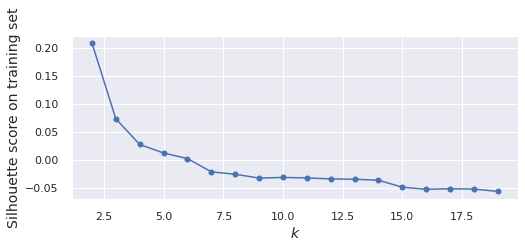

In [36]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 20), silhouette_scores_nltk, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score of KMeans NLTK (with cosine distance) on training set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores_test, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score on test set", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()